In [42]:
import torchvision.datasets as datasets
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [66]:
class KNNClassifier:
    def __init__(self, X, Y):
        self.X_clf = np.array(X)
        self.Y_clf = np.array(Y)

    def classify(self, x, k, dist_func=np.linalg.norm, decision_weighted=False):
        # Implement the k-NN classifier
        # x is a single vector to classify
        # k is the number of neighbors to consider
        # returns the most common class among the k nearest neighbors
        if self.X_clf is None or self.Y_clf is None:
            raise Exception("Classifier not trained")

        # Vectorized implementation for speed
        distances = dist_func(self.X_clf - x, axis=1)
        sorted_indices = np.argsort(distances)
        k_nearest_indices = sorted_indices[:k]
        k_nearest_labels = self.Y_clf[k_nearest_indices]
        # count the number of 0s and 1s
        count0 = 0
        count1 = 0
        if decision_weighted:
            for i in range(len(k_nearest_indices)):
                if k_nearest_labels[i] == 0:
                    count0 += 1 / distances[k_nearest_indices[i]]
                else:
                    count1 += 1 / distances[k_nearest_indices[i]]
        else:
            for i in range(len(k_nearest_indices)):
                if k_nearest_labels[i] == 0:
                    count0 += 1
                else:
                    count1 += 1
        # return the most common class
        if count0 > count1:
            return 0
        else:
            return 1

    def plot_decision_boundary(self, k, dist_func=np.linalg.norm, decision_weighted=False, h=50):
        x_min, x_max = self.X_clf[:, 0].min() - 1, self.X_clf[:, 0].max() + 1
        y_min, y_max = self.X_clf[:, 1].min() - 1, self.X_clf[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = np.zeros(xx.shape)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                Z[i, j] = self.classify(np.array([xx[i, j], yy[i, j]]), k, dist_func, decision_weighted)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.scatter(self.X_clf[:, 0], self.X_clf[:, 1], c=self.Y_clf, cmap=plt.cm.coolwarm)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"{k}-NN decision boundary")

        # legend
        red_patch = mpatches.Patch(color='red', label='Class 0')
        blue_patch = mpatches.Patch(color='blue', label='Class 1')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()
        
class MED_Classifier:
    def __init__(self, X, Y):
        self.X_clf = X
        self.Y_clf = Y
        self.prototypes = self.compute_prototypes(X, Y)

    def compute_prototypes(self, X, Y):
        # Compute the prototypes
        # X is a list of vectors
        # Y is a list of labels
        # returns a list of two vectors, the prototypes
        self.prototype0 = np.mean([X[i] for i in range(len(X)) if Y[i] == 0], axis=0)
        self.prototype1 = np.mean([X[i] for i in range(len(X)) if Y[i] == 1], axis=0)
        return [self.prototype0, self.prototype1]

    def classify(self, x):
        # Implement the MED classifier
        # x is a single vector to classify
        # returns the classification of x by nearest euclidean distance to prototype
        if self.X_clf is None or self.Y_clf is None:
            raise Exception("Classifier not trained")
        dist0 = np.linalg.norm(self.prototype0 - x)
        dist1 = np.linalg.norm(self.prototype1 - x)
        if dist0 < dist1:
            return 0
        else:
            return 1

    def plot_decision_boundary(self, h=10):
        if self.X_clf is None or self.Y_clf is None:
            raise Exception("Classifier not trained")
        x_min, x_max = self.X_clf[:, 0].min() - 1, self.X_clf[:, 0].max() + 1
        y_min, y_max = self.X_clf[:, 1].min() - 1, self.X_clf[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = np.zeros(xx.shape)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                Z[i, j] = self.classify(np.array([xx[i, j], yy[i, j]]))
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.scatter(self.X_clf[:, 0], self.X_clf[:, 1], c=self.Y_clf, cmap=plt.cm.coolwarm)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())



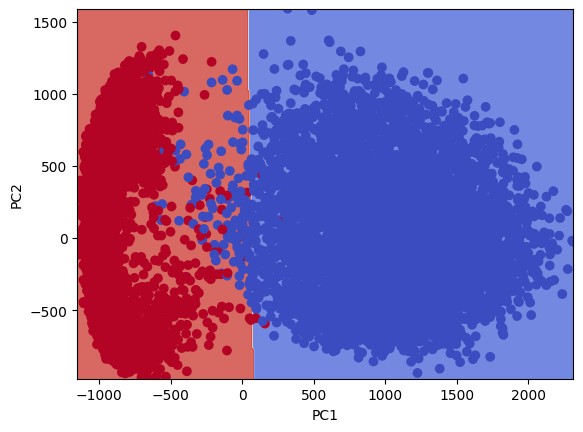

In [67]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
X_PC, Y = prep_mnist(mnist_trainset, 2)
X_test_PC, Y_test = prep_mnist(mnist_testset, 2)

med_clf = MED_Classifier(X_PC, Y)
med_clf.plot_decision_boundary()

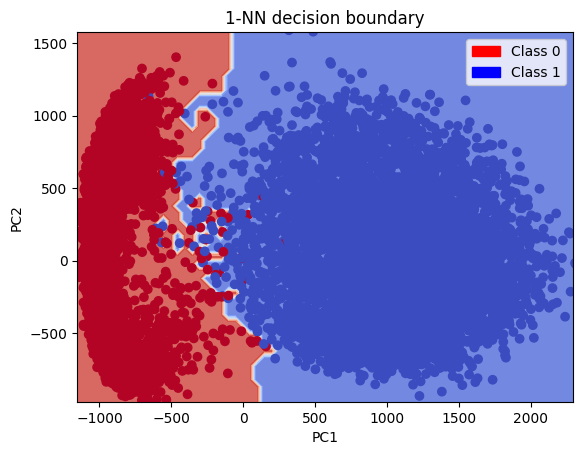

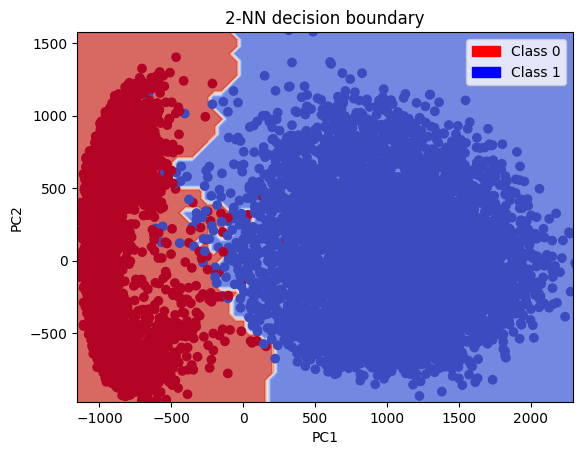

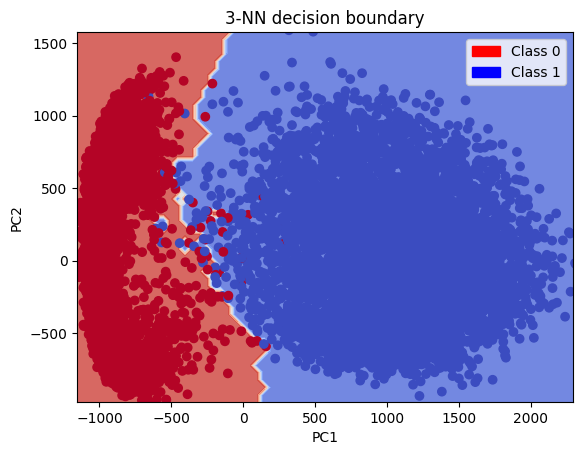

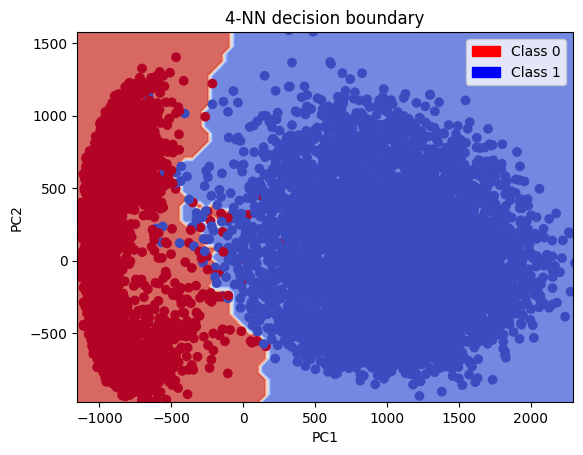

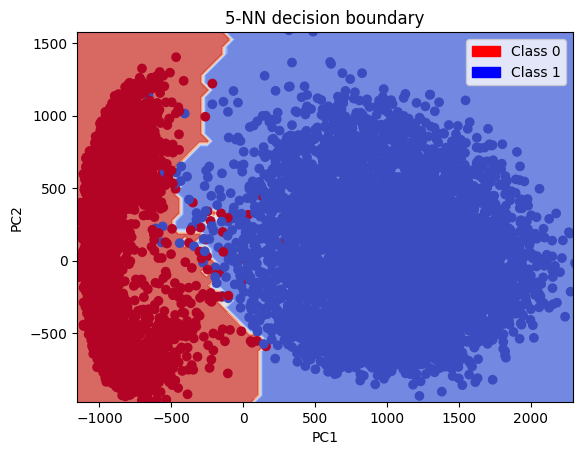

In [44]:
K_VALUES = [1, 2, 3, 4, 5]
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

X_PC, Y = prep_mnist(mnist_trainset, 2)
X_test_PC, Y_test = prep_mnist(mnist_testset, 2)

knn = KNNClassifier(X_PC, Y)
preds_results = {}
for k_val in K_VALUES:
    knn.plot_decision_boundary(k_val)
    preds_results[k_val] = []
    for i in range(len(X_test_PC)):
        pred = knn.classify(X_test_PC[i], k_val)
        preds_results[k_val].append((pred, Y_test[i]))


In [46]:
X_PC, Y

(array([[1119.66338805,  321.49796415],
        [-883.61589229,  907.3863322 ],
        [-798.39309386, -842.90958277],
        ...,
        [-726.57401034,  652.36411163],
        [ 816.3685892 ,  679.55858522],
        [-821.88725405,  356.09634105]]),
 [0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,


In [39]:
for k_val in preds_results:
    correct = 0
    for pred in preds_results[k_val]:
        if pred[0] == pred[1]:
            correct += 1
    print(f"KNN with k:{k_val} is {correct/len(preds_results[k_val])}")
    

KNN with k:1 is 0.9962174940898345
KNN with k:2 is 0.9947990543735225
KNN with k:3 is 0.9981087470449173
KNN with k:4 is 0.9971631205673759
KNN with k:5 is 0.9985815602836879


(12665, 2)